<a href="https://colab.research.google.com/github/BillWorstell/PyTomography/blob/main/t_OSL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

See https://pytomography.readthedocs.io/en/latest/notebooks/t_OSL.html

See https://pytomography.readthedocs.io/en/latest/usage.html

Modified to run from Google Colab:
https://colab.research.google.com/

Data stored on Google Drive in path = '/content/drive/MyDrive/pytomography_tutorial_data/simind_tutorial/'

May require restart after first run

Tested with V100 GPU on Colab

In [1]:
!pip install kaleido
!pip install monai
!pip install uvicorn
!pip install fastapi
!pip install python-multipart
!pip install pytomography

OSEMOSL

The following tutorial is an introduction to using Bayesian priors in SPECT imaging. It uses a basic algorithm: the OSEM “one step late” (OSEMOSL) to encorporate prior information.

For a more comprehensive analysis using the superior BSREM algorithm, see the SPECT: BSREM tutorial. However, it is suggested that you go through this tutorial first as a learning exercise before attempting reconstruction with BSREM

In [2]:
import os
from pytomography.io.SPECT import simind
from pytomography.priors import RelativeDifferencePrior
from pytomography.projectors import SPECTSystemMatrix
from pytomography.transforms import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.algorithms import OSEMOSL
from pytomography.priors import QuadraticPrior, RelativeDifferencePrior
from pytomography.priors import TopNAnatomyNeighbourWeight
from torch import poisson
import matplotlib.pyplot as plt

Modify the path below to where you saved the files:

In [3]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/pytomography_tutorial_data/simind_tutorial/'

Mounted at /content/drive


The first cell of code is borrowed from the SPECT: Reconstructing SIMIND Data tutorial in the multiple regions case. For a more comprehensive description about the code below, please see that tutorial.

In [4]:
organs = ['bkg', 'liver', 'l_lung', 'r_lung', 'l_kidney', 'r_kidney','salivary', 'bladder']
activities = [2500, 450, 7, 7, 100, 100, 20, 90] # MBq
headerfiles = [os.path.join(path, 'multi_projections', organ, 'photopeak.h00') for organ in organs]
headerfiles_lower = [os.path.join(path, 'multi_projections', organ, 'lowerscatter.h00') for organ in organs]
headerfiles_upper = [os.path.join(path, 'multi_projections', organ, 'upperscatter.h00') for organ in organs]
object_meta, proj_meta = simind.get_metadata(headerfiles[0]) #assumes the same for all
photopeak = simind.combine_projection_data(headerfiles, activities)
scatter = simind.combine_scatter_data_TEW(headerfiles, headerfiles_lower, headerfiles_upper, activities)
# Convert from CPS to counts
dT = 15 #s
photopeak *= dT
scatter *= dT
photopeak_poisson = poisson(photopeak)
scatter_poisson = poisson(scatter)
# Obtain required transforms to build system matrix
attenuation_map = simind.get_attenuation_map(os.path.join(path, 'multi_projections', 'mu208.hct'))
att_transform = SPECTAttenuationTransform(attenuation_map)
psf_meta = simind.get_psfmeta_from_header(headerfiles[0])
psf_transform = SPECTPSFTransform(psf_meta)
system_matrix = SPECTSystemMatrix(
    obj2obj_transforms = [att_transform,psf_transform],
    proj2proj_transforms = [],
    object_meta = object_meta,
    proj_meta = proj_meta,
    n_parallel=8)

Once the system matrix is setup, its time to define the priors for the reconstruction algorithm. PyTomography has many useful prior functions for SPECT reconstruction. Most of them are derived from NearestNeighbourPrior; meaning prior information for each voxel only depends on the neighbouring 26 voxels. Priors can be defined as follows:

In [5]:
prior_quad = QuadraticPrior(beta=0.3)
prior_rdp = RelativeDifferencePrior(beta=0.3, gamma=2)

By default, the “contribution” (or weight) from the 26 neighbouring voxels is scaled by the Euclidean distance from the central voxel. Voxels on the corners (8 total) therefore only contribute
 compared to the adjacent 6 (up/down, left/right, front/back). The weight in this case is an instance of EuclideanNeighbourWeight.

PyTomography also has options to use other weights for neighbouring voxels. For example, it can use anatomical images (such as attenuation maps and CT images) to obtain a different weighting scheme. For example, the TopNAnatomyNeighbourWeight is an extension of EuclideanNeighbourWeight that only uses non-zero weights for the top-N closest neighbours based on an external anatomical image:

In [6]:
weight_top8anatomy = TopNAnatomyNeighbourWeight(attenuation_map, N_neighbours=8)

This can be used to create custom priors with the given weighing. These are typically referred to as anatomical priors (AP) and would be designated as Quadratic-AP or RDP-AP

In [7]:
prior_quad_weighttop8 = QuadraticPrior(beta=0.3, weight=weight_top8anatomy)
prior_rdp_weighttop8 = RelativeDifferencePrior(beta=0.3, gamma=2, weight=weight_top8anatomy)

We can now reconstruct this object using no prior, and the four prior functions we just defined

In [8]:
def reconstruct(
    prior = None,
    n_iters=40,
    n_subsets=8,
):
    reconstruction_algorithm = OSEMOSL(
    projections = photopeak_poisson,
    system_matrix = system_matrix,
    scatter = scatter_poisson,
    prior=prior)
    return reconstruction_algorithm(n_iters, n_subsets)

Now we can reconstruct using a variety of different prior functions, and view the results:

In [9]:
recon_noprior = reconstruct(None)
recon_quad = reconstruct(prior_quad)
recon_rdp = reconstruct(prior_rdp)
recon_quad_weighttop8 = reconstruct(prior_quad_weighttop8)
recon_rdp_weighttop8 = reconstruct(prior_rdp_weighttop8)

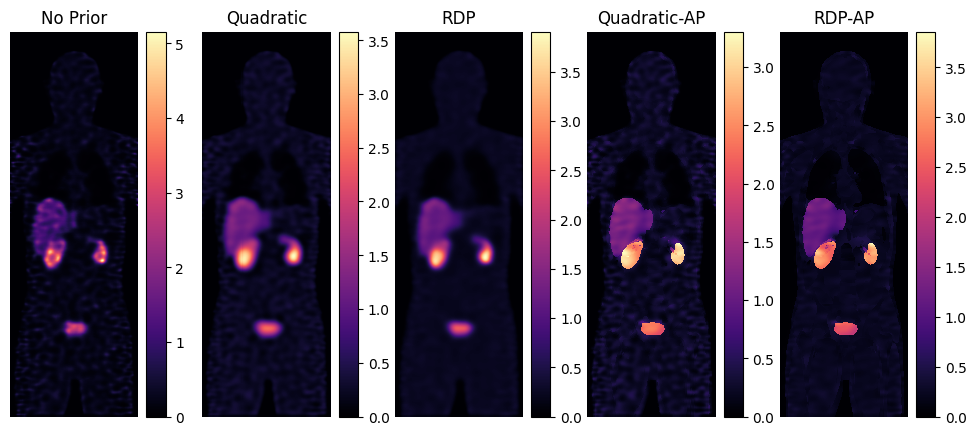

In [10]:
plt.subplots(1,5,figsize=(12,5))
plt.subplot(151)
plt.pcolormesh(recon_noprior[0].cpu()[:,70].T, cmap='magma')
plt.colorbar()
plt.axis('off')
plt.title('No Prior')
plt.subplot(152)
plt.pcolormesh(recon_quad[0].cpu()[:,70].T, cmap='magma')
plt.colorbar()
plt.axis('off')
plt.title('Quadratic')
plt.subplot(153)
plt.pcolormesh(recon_rdp[0].cpu()[:,70].T, cmap='magma')
plt.colorbar()
plt.axis('off')
plt.title('RDP')
plt.subplot(154)
plt.pcolormesh(recon_quad_weighttop8[0].cpu()[:,70].T, cmap='magma')
plt.colorbar()
plt.axis('off')
plt.title('Quadratic-AP')
plt.subplot(155)
plt.pcolormesh(recon_rdp_weighttop8[0].cpu()[:,70].T, cmap='magma')
plt.colorbar()
plt.axis('off')
plt.title('RDP-AP')
plt.show()